# Local File Tutorial

The goal of this notebook is to provide a tutorial for working with local files and custom event catalogs. See the quick_start.ipynb tutorial for working with event catalogs and data retrieved from a `Client`. 

## Matched-filter signal detection on local files with EQcorrscan
One of the main applications of EQcorrscan is to detect earthquakes or other seimic signals
using matched-filters (aka template-matching).  To undertake matched-filtering templates are
required.  Templates are simply processed waveforms. In EQcorrscan templates are realised
as `Template` objects, which contain the waveform data and meta-data associated with their
creation. Groups of `Template` objects are stored in `Tribe` objects. To demonstrate this, we
will create a `Tribe` for a M1.1 event in Southern Alaska.

Before we begin we will set up logging - EQcorrscan provides textual output through the 
native Python [logging library](https://docs.python.org/3/library/logging.html). The standard
`DEBUG`, `INFO`, `WARNING`, `ERROR` and `CRITICAL` levels are supported.  For this we will
set to `ERROR` to reduce the output.  When starting off you might want to set to `INFO`,
or if something is happening that you don't expect, `DEBUG` will give you much more output.

In [1]:
# set up logging
import logging

logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

Now we need a catalog of events. You can either download a catalog using `client.get_events` as shown in the quick start tutorial, or you can build your own catalog following the example below. To build a custom event catalog compatible with EQcorrscan the phase arrival times need to be stored in a Obspy catalog complete with network and channel information for each station. First we generate a HYPODD format file, then read it into an Obspy catalog, then complete the catalog with missing network and channel information. 

In [2]:
# build catalog of events to use as templates

from obspy import UTCDateTime, Stream, read, read_events

# create HYPODD format file with template events to import them into EQcorrscan
# entries are: #, YR, MO, DY, HR, MN, SC, LAT, LON, DEP, MAG, EH, EZ, RMS, ID 
#              followed by lines of observations: STA, TT, WGHT, PHA
# as specified here: https://www.ldeo.columbia.edu/~felixw/papers/Waldhauser_OFR2001.pdf
templates = ["# 2016  9 26  8 52 40.00  61.9833 -144.0437   1.70  1.10  0.0  0.0  0.00  1\n",
             "RH08    5.180  1       P\n",
             "NEB1    5.809  1       P\n",
             "NEB3    5.661  1       P\n"]

# now write to Obspy readable catalog file
with open("templates.pha", "w") as file:
    for line in templates:
        file.write(line)

# read the file into an Obspy catalog
catalog = read_events("templates.pha", format="HYPODDPHA")

# complete missing catalog info (information required by EQcorrscan)
# station dict to add data needed by EQcorrscan
station_dict = {"RH08": {"network": "YG", "channel": "BHZ"},
                "NEB1": {"network": "YG", "channel": "BHZ"},
                "NEB3": {"network": "YG", "channel": "BHZ"}}
# assign network and channel to catalog
for event in catalog.events:
    for pick in event.picks:
        if pick.waveform_id.station_code in station_dict:
            pick.waveform_id.network_code = station_dict[pick.waveform_id.station_code]["network"]
            pick.waveform_id.channel_code = station_dict[pick.waveform_id.station_code]["channel"]

# inspect the contents
catalog[0].picks

[Pick
	 resource_id: ResourceIdentifier(id="smi:local/ea3eb3f5-a380-4841-8a6f-05e49bc13083")
	        time: UTCDateTime(2016, 9, 26, 8, 52, 45, 180000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='RH08', channel_code='BHZ', location_code='')
	  phase_hint: 'P',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/91501389-693d-4b71-81d5-9f76c1dffeec")
	        time: UTCDateTime(2016, 9, 26, 8, 52, 45, 809000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='NEB1', channel_code='BHZ', location_code='')
	  phase_hint: 'P',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/00f1ddc9-a89d-42fc-a7c2-a25ddff68ce4")
	        time: UTCDateTime(2016, 9, 26, 8, 52, 45, 661000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='NEB3', channel_code='BHZ', location_code='')
	  phase_hint: 'P']

EQcorrscan can be used with data directly from a `Client` or local data. In the cell below, data is downloaded locally to the 'data' directory, and later used for event detection. 

In [3]:
# download data for specified stations locally to the 'data' directory
from obspy.clients.fdsn import Client
import os

# make directory for data
os.mkdir("./data")

# helper function to download data from IRIS DMC via Obspy
def download_Waveforms(network, stations, location, channels, start_Time, end_Time):
    client = Client("IRIS")
    
    for station in stations:
        for channel in channels:
            st = client.get_waveforms(network, station, location, channel,
                                      start_Time, end_Time)
            # fix rounding errors in sampling rate before merging
            for index, trace in enumerate(st):
                st[index].stats.sampling_rate = round(trace.stats.sampling_rate)

            # do not fill with 0's when using EQcorrscan
            st = st.merge(method=1, fill_value=None)
            
            filename = f"{network}.{station}.{channel}" \
                           f".{start_Time.year}" \
                           f"-{start_Time.month:02}-" \
                           f"{start_Time.day:02}.ms"

            st.write(f"./data/{filename}", format="MSEED")

# 1 day of data downloaded for three stations in the YG network
network = "YG"
stations = ["RH08", "NEB1", "NEB3"]
location = "**"
channels = ["BHZ", "BHN", "BHE"]
# the date range
start_Time = UTCDateTime("2016-09-26T00:00:00.0Z")
end_Time =   UTCDateTime("2016-09-26T23:59:59.999999Z")
# download the files
download_Waveforms(network, stations, location, channels, start_Time, end_Time)

In [4]:
# load templates from local data and catalog generated above

from eqcorrscan import Tribe
    
# build stream of all stations for detection from 'data' directory
import glob
files_path = "./data"
file_list = glob.glob(f"{files_path}/*.ms")

# load files into stream
st = Stream()
for file in file_list:
    st += read(file)
    
# update process_len to the duration in seconds
process_len = round(end_Time - start_Time)

# bandpass 1-15 Hz, 5.0 second template + 1.0 s prepick = 6.0 second template
tribe = Tribe().construct(
    method="from_meta_file", meta_file=catalog, st=st, lowcut=1.0, highcut=15.0, 
    samp_rate=40.0, length=5.0, filt_order=4, prepick=1.0, swin='all',
    process_len=process_len, parallel=True)
print(tribe)

Tribe of 1 templates


This makes a tribe by:

1. Loading data from the Stream built from local files;
2. Detrending, filtering and resampling the data;
3. Trimming the data around picks within each event in the catalog.
    
To make this `Tribe` we used a few different arguments:

- `method`: The 'from_meta_file' method specifies to load a catalog from a file or Obspy catalog object.  
- `meta_file`: The file or Obspy catalog object to load the event catalog from.
- `st`: The Stream containing the local data. 
- `lowcut`: This controls the lower corner frequency of a filter in Hz.  EQcorrscan
  natively uses Obspy's butterworth filter functions.  For more details, see the 
  [Obspy docs](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html).
  This can optionally be set to `None` to not apply filtering at low frequencies.
- `highcut`: This controls the upper corner frequency of a filter in Hz. It is applied
  in tandem with lowcut, or can be set to `None` to not apply filtering at high frequencies.
- `samp_rate`: The desired sampling-rate of the templates in Hz.  EQcorrscan requires that
  templates and continuous data be sampled at the same rate.  In this case we are downsampling
  data from 100.0 Hz to 50.0 Hz.  We do this to reduce memory-load. EQcorrscan uses Obspy's
  [resampling method](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html#obspy.core.stream.Stream.resample)
- `length`: This is the length of the template waveform on each channel in seconds.
- `filt_order`: This sets the number of corners/order of the filter applied using
  `highcut` and `lowcut`.
- `prepick`: The number of seconds prior to a phase-pick to start a template waveform.
- `catalog`: The catalog of events to generate templates for.
- `process_len`: The length of data to download in seconds for each template. This should be
  the same as the length of your continuous data, e.g. if you data are in day-long files, this
  should be set to `86400`.
- `parallel`: Whether to process the data in parallel or not.  This will increase memory load,
  if you find yourself running out of memory, set `parallel=False` for these template
  construction methods.
      
Lets have a quick look at the attributes of a `Template`:

Template 2016_09_26t08_52_44: 
	 3 channels;
	 lowcut: 1.0 Hz;
	 highcut: 15.0 Hz;
	 sampling rate 40.0 Hz;
	 filter order: 4; 
	 process length: 86400.0 s


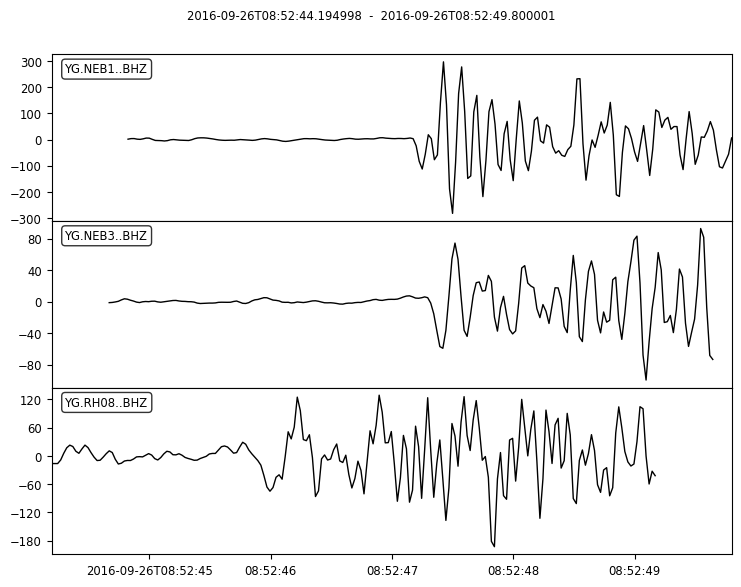

In [5]:
# inspect first template
print(tribe[0])
fig = tribe[0].st.plot(equal_scale=False, size=(800, 600))

We can see that this template has data from multiple stations, and that our processing parameters
are stored alongside the template waveform.  This means that we can ensure that when we work
on continuous data to run matched-filtering the data are processed in the same way.

Next we use this tribe to detect earthquakes within one day of data from Southern Alaska. We utilize the same Stream object built above, which contains data for September 26, 2016.

This next cell will:

1. Process the data in the same way as the templates in the `Tribe` (note that your
   tribe can contain templates processed in different ways: these will be grouped into
   similarly processed templates and the matched-filter process will be run multiple
   times; once for each group of similar templates);
2. Cross-correlate the templates with the processed data and stack the correlations;
3. Detect within each templates stacked cross-correlation array based on a given threshold;
4. Generate `Detection` objects with Obspy events and meta-data
    
Again, we use a few arguments here:

- `st`: This again is the stream of data built from local files;
- `threshold`: The threshold for detection: note that the correlation sum is both
  positive and negative valued.  Detections are made based on the absolute of the
  correlation vector, so both postively and negatively correlated detections are made;
- `daylong`: Uses efficient preprocessing for files that span 1 day;
- `threshold_type`: The type of threshold to use, in this case we used `"MAD"`, the
  median absolute deviation, our `threshold` is the MAD multiplier;
- `trig_int`: The minimum time (in seconds) between triggers.  The highest absolute
  correlation value will be used within this window if multiple possible triggers
  occur.  Note that this only applies within the detections from one template.
- `plot`: We turned plotting off in this case;
- `return_stream`: Setting this to `True` will return the pre-processed stream, allowing us to reuse this stream for later processing.
- `parallel_process`: Utilize parallel processing;

A `Party` will be returned after detection.  The `Party` is a container for `Family` objects. Each
`Family` contains a `Template` and all the detections associated with that `Template`.  Detections
are stored as `Detection` objects.
      
Lets run the detection and have a look at the cumulative detections we made.

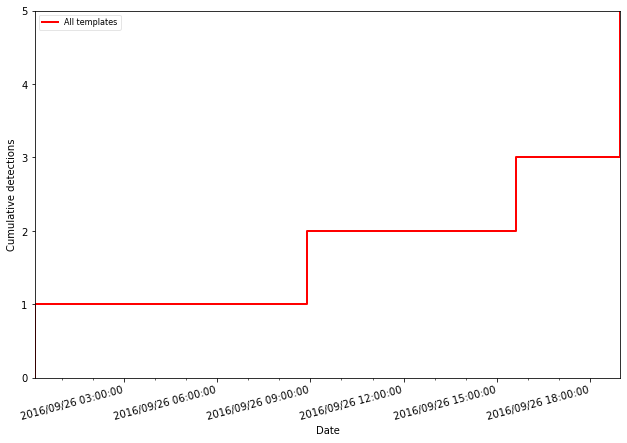

Family of 5 detections from template 2016_09_26t08_52_44


In [6]:
# use tribe to detect events in local data

# detect instances above 8.0x MAD
party = tribe.detect(stream=st, threshold=8.0, daylong=False, threshold_type="MAD", trig_int=8.0,
                     plot=False, return_stream=False, parallel_process=True)

# inspect the party detections
fig = party.plot(plot_grouped=True)

# peek at most productive family
family = sorted(party.families, key=lambda f: len(f))[-1]
print(family)

Detection on template: 2016_09_26t08_52_44 at: 2016-09-26T00:07:29.200001Z with 3 channels: [('NEB1', 'BHZ'), ('NEB3', 'BHZ'), ('RH08', 'BHZ')]


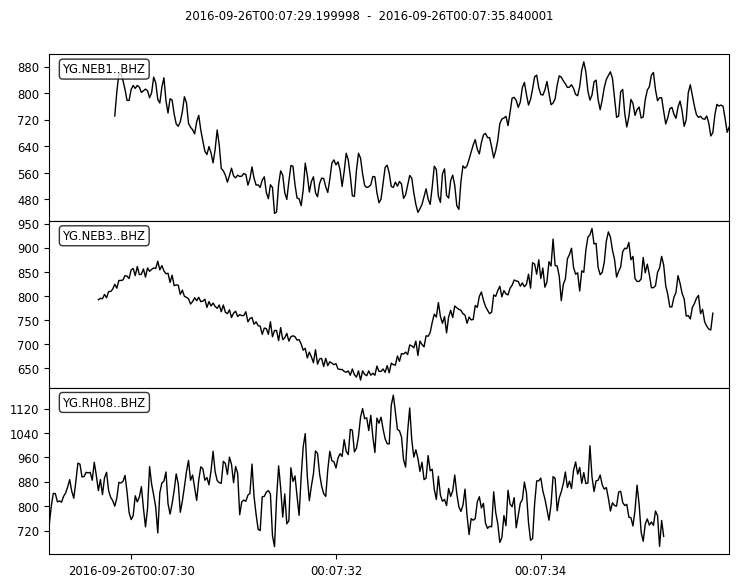

In [7]:
# get a dict of streams for each detection in a family and plot the first detection

streams = family.extract_streams(stream=st, length=6, prepick=1.0)
print(family.detections[0])
fig = streams[family.detections[0].id].plot(equal_scale=False, size=(800, 600))